## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

### Dependencies
gym==0.21.0     
torch==2.1.0.dev20230526

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to alleviate the problems of correlated data and non-stationary distributions

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, apply a custom **Cropping** wrapper, and a **resize wrapper**

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Additionally, a **RescaleRange** wrapper is applied to normalize input value range from 0-255 to 0-1

State shape:  (4, 84, 84, 1)
Info  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


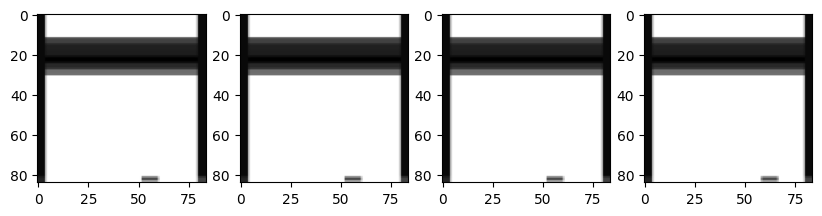

Low value 0.0 - High value 0.5803921818733215


In [6]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation
from utilities.custom_wrappers import ClipReward, AtariCropping, RescaleRange

def generate_env(env_name):
    env = gym.make(env_name)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    env = RescaleRange(env)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("BreakoutDeterministic-v4")
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
print("State shape: ", np.asarray(observation).shape)
print("Info ", info)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap="binary")
plt.show()

print(f"Low value {np.min(np.asarray(observation))} - High value {np.max(np.asarray(observation))}")

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [5]:
import random

def choose_action(model, state, device, epsilon=0.001):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
        with torch.no_grad():
    #         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
            state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
            # predict
            pred = model(state)
            action = torch.argmax(pred.squeeze()).item()
            return int(action)

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$) in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [6]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
    loss = (expected_qs-old_qs).pow(2).mean()
    
    # improvement for stability - use different loss 
#     loss_func = nn.HuberLoss()
#     loss = loss_func(old_qs, expected_qs)
    
    return loss

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward** and **predicted Q** value of a <u>held out set of states</u> 

In [7]:
def eval_model(model, env_id, eval_steps=10000, device="mps"):
    env=generate_env(env_id)
    curr_state = env.reset()
    curr_state = np.asarray(curr_state)
    
    episode_rewards = [0]
    
    for i in range(eval_steps):
        action = choose_action(model, curr_state, device, epsilon=0.05)
        
        observation, reward, done, _ = env.step(action)
        observation = np.asarray(observation) #convert to np array
        
        episode_rewards[-1]+=reward
        curr_state = observation
        
        if done:
            # end of episode -> reset env, create new total reward for episode
            curr_state = env.reset()
            curr_state = np.asarray(curr_state)
            episode_rewards.append(0)
            
    # calculate mean episode
    episode_reward = np.array(episode_rewards)
    return np.mean(episode_reward)

### Parameters

In [11]:
# ------- Set up parameters -------
ENV = "BreakoutDeterministic-v4"
LOG_FREQ = 20 #number of EPISODES in-between logging results 
EVAL_FREQ = 50000 #number of STEPS before evaluate model
CHECKPOINT_FREQ = 250000 #number of STEPS before saving model
SAVE_DIR = "Breakout_PenalizeLoseLives" #directory to save stuffs

# ------ Hyper parameters ---------
LEARNING_RATE = 0.00001 if ENV == "BreakoutDeterministic-v4" else 0.00025
REPLAY_LEN = 100000 # 1000000 in paper, but I still like mah laptop, so no
BATCH_SIZE = 32
EPISODES = 15000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=True # whether to have target model or not
UPDATE_TARGET=1000 #steps to run before updating the target model

### Setting up variables before training

In [12]:
# ------- Set up device, check for mps, cuda or cpu -----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ------- Set up env ----------------
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# ------- Set up model ----------------
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# ------- Set up optimizer ----------------
# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------- Set up stats tracker ----------------
steps = 0 # no. of steps
highest_reward = 0 # highest evaluation reward
epsilon = 1

# ------- Set up replay buffer ----------------
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
prev_lives = 0 # keep track of previous life
for i in range(BATCH_SIZE):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # encode losing life as ending episode to penalize losing life
    terminated = (info['lives'] < prev_lives) or done
    prev_lives = info['lives']
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, terminated)
    
    # update curr state
    curr_state = observation
    
    if done:
        curr_state = env.reset()
        curr_state = np.asarray(curr_state)
        prev_lives = 0
print(f"Initial length of replay memory: {len(replay_memory)}")

# ------- Set up saving dir ----------------
sub_folders = ["checkpoints", "tensorboard_runs"] # list of subfolders
for sub_folder in sub_folders:
    path = f"{SAVE_DIR}/{sub_folder}/"
    if not os.path.exists(path):
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"{path} created")
        
# ------- Set up Tensorboard --------------
sample_input = replay_memory.sample(32)
#     Transpose 
sample_input = Experience(*zip(*sample_input))
#     convert to a single np.array for faster tensor conversion
sample_state = np.array(sample_input.state)
# Tensor-ify state, action, reward, successor, done
sample_state = torch.Tensor(sample_state).squeeze().to(device)

writer = SummaryWriter(log_dir=f"{SAVE_DIR}/tensorboard_runs/")
writer.add_graph(model, sample_state) # add graph for model

print(f'Start Tensorboard by running this command from project folder: tensorboard --logdir="{SAVE_DIR}/tensorboard_runs"')

Device: mps
Current Atari environment: BreakoutDeterministic-v4
Learning rate: 1e-05
Initial length of replay memory: 32
Start Tensorboard by running this command from project folder: tensorboard --logdir="Breakout_PenalizeLoseLives/tensorboard_runs"


### Training process

In [13]:
with tqdm(total=EPISODES, unit="eps") as pbar:

    # main training loop
    for i in range(EPISODES):
        curr_state = env.reset()
        curr_state = np.asarray(curr_state) #convert to np array
        loss_val = 0 # loss value for curr episode
        reward_val = 0 # reward value for curr episode
        prev_lives = 0
        
        while True:
        # ---------- Epsilon decay logic ------------
            # decay over the first million frames then stay at 0.1
            decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
            epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
            
        # ---------- Training steps logic ------------
            # execute action
            action = choose_action(model, curr_state, device, epsilon=epsilon)
            observation, reward, done, _ = env.step(action)
            observation = np.asarray(observation) #convert to np array
            
            # encode losing life as ending episode to penalize losing life
            terminated = (info['lives'] < prev_lives) or done
            prev_lives = info['lives']
            
            # save observation
            replay_memory.push(curr_state, action, reward, observation, terminated)

            # update curr_state
            curr_state = observation

            # sample and compute loss
            loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
            loss_item = loss.item()
            
            # zero out gradient before backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---------- Logging and update various stuffs ------------
            # update target model if available
            if USE_TARGET_MODEL:
                if steps%UPDATE_TARGET:
                    target_model.load_state_dict(model.state_dict())

            # update loss as the max loss during episode
            loss_val = max(loss_item, loss_val)
            # add steps count for epsilon decay
            steps+=1
            # update total reward of episode
            reward_val += reward

            if steps%CHECKPOINT_FREQ==0:
                with open(f"{SAVE_DIR}/checkpoints/{steps}.pt", 'wb') as f:
                    torch.save(model.state_dict(), f)

            if steps%EVAL_FREQ==0:
                pbar.write("------- Evaluating --------")
                # eval steps
                eval_reward = eval_model(model, ENV, eval_steps=10000, device=device)   
#                 eval_rewards.append(eval_reward)
                pbar.write(f"Evaluation reward (average per episode) {eval_reward}")
                pbar.write("---------------------------")
                writer.add_scalar("Eval | Average reward/episode over Steps", eval_reward, steps)
                highest_reward = max(highest_reward, eval_reward)
                
        # ------ Clean up after each 200 step ------
            del loss
            if steps%200==0:
                gc.collect()

            if done: 
                # finish an episode
                break
                
    # ------ Update training episode stats, use tqdm instead of printing -----
        pbar.update(1)
        pbar.set_description(desc=f"Ep:{i+1}|{steps}steps|Loss:{round(loss_val, 4)}|Reward:{reward_val}")
        
    # ------- Log training loss and training episode rewards for tensorboard
        if i%LOG_FREQ==0:
            writer.add_scalar("Train | Loss over Episode", loss_val, i)
            writer.add_scalar("Train | Reward over Episode", reward_val, i)
            
            
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest eval reward {highest_reward}")

Ep:274|49881steps|Loss:0.1046|Reward:1.0:   2%|▍                         | 274/15000 [08:52<8:28:45,  2.07s/eps]

------- Evaluating --------


Ep:274|49881steps|Loss:0.1046|Reward:1.0:   2%|▍                         | 274/15000 [09:08<8:28:45,  2.07s/eps]

Evaluation reward (average per episode) 0.3888888888888889
---------------------------


Ep:554|99932steps|Loss:0.0788|Reward:0.0:   4%|▉                         | 554/15000 [18:53<8:07:29,  2.02s/eps]

------- Evaluating --------


Ep:554|99932steps|Loss:0.0788|Reward:0.0:   4%|▉                         | 554/15000 [19:08<8:07:29,  2.02s/eps]

Evaluation reward (average per episode) 2.0384615384615383
---------------------------


Ep:825|149984steps|Loss:0.1066|Reward:3.0:   6%|█▍                       | 825/15000 [29:29<9:42:03,  2.46s/eps]

------- Evaluating --------


Ep:825|149984steps|Loss:0.1066|Reward:3.0:   6%|█▍                       | 825/15000 [29:45<9:42:03,  2.46s/eps]

Evaluation reward (average per episode) 4.866666666666666
---------------------------


Ep:1069|199946steps|Loss:0.1386|Reward:4.0:   7%|█▌                    | 1069/15000 [40:19<10:48:10,  2.79s/eps]

------- Evaluating --------


Ep:1069|199946steps|Loss:0.1386|Reward:4.0:   7%|█▌                    | 1069/15000 [40:37<10:48:10,  2.79s/eps]

Evaluation reward (average per episode) 3.0
---------------------------


Ep:1292|249876steps|Loss:0.1521|Reward:1.0:   9%|█▉                     | 1292/15000 [51:15<9:39:54,  2.54s/eps]

------- Evaluating --------


Ep:1292|249876steps|Loss:0.1521|Reward:1.0:   9%|█▉                     | 1292/15000 [51:32<9:39:54,  2.54s/eps]

Evaluation reward (average per episode) 2.875
---------------------------


Ep:1530|299847steps|Loss:0.0835|Reward:1.0:  10%|██▏                  | 1530/15000 [1:02:15<8:29:21,  2.27s/eps]

------- Evaluating --------


Ep:1530|299847steps|Loss:0.0835|Reward:1.0:  10%|██▏                  | 1530/15000 [1:02:31<8:29:21,  2.27s/eps]

Evaluation reward (average per episode) 3.0
---------------------------


Ep:1800|349918steps|Loss:0.0984|Reward:3.0:  12%|██▌                  | 1800/15000 [1:13:12<9:42:18,  2.65s/eps]

------- Evaluating --------


Ep:1800|349918steps|Loss:0.0984|Reward:3.0:  12%|██▌                  | 1800/15000 [1:13:29<9:42:18,  2.65s/eps]

Evaluation reward (average per episode) 0.11392405063291139
---------------------------


Ep:2056|399870steps|Loss:0.0943|Reward:1.0:  14%|██▉                  | 2056/15000 [1:24:14<8:16:44,  2.30s/eps]

------- Evaluating --------


Ep:2056|399870steps|Loss:0.0943|Reward:1.0:  14%|██▉                  | 2056/15000 [1:24:30<8:16:44,  2.30s/eps]

Evaluation reward (average per episode) 1.15625
---------------------------


Ep:2281|449980steps|Loss:0.1266|Reward:5.0:  15%|███                 | 2281/15000 [1:35:01<10:41:52,  3.03s/eps]

------- Evaluating --------


Ep:2281|449980steps|Loss:0.1266|Reward:5.0:  15%|███                 | 2281/15000 [1:35:17<10:41:52,  3.03s/eps]

Evaluation reward (average per episode) 1.3548387096774193
---------------------------


Ep:2496|499806steps|Loss:0.1038|Reward:2.0:  17%|███▍                 | 2496/15000 [1:45:45<9:30:21,  2.74s/eps]

------- Evaluating --------


Ep:2496|499806steps|Loss:0.1038|Reward:2.0:  17%|███▍                 | 2496/15000 [1:46:01<9:30:21,  2.74s/eps]

Evaluation reward (average per episode) 1.4915254237288136
---------------------------


Ep:2695|549870steps|Loss:0.1206|Reward:0.0:  18%|███▌                | 2695/15000 [1:56:32<10:27:11,  3.06s/eps]

------- Evaluating --------


Ep:2695|549870steps|Loss:0.1206|Reward:0.0:  18%|███▌                | 2695/15000 [1:56:48<10:27:11,  3.06s/eps]

Evaluation reward (average per episode) 3.3095238095238093
---------------------------


Ep:2884|599952steps|Loss:0.1302|Reward:3.0:  19%|███▊                | 2884/15000 [2:07:21<12:02:03,  3.58s/eps]

------- Evaluating --------


Ep:2884|599952steps|Loss:0.1302|Reward:3.0:  19%|███▊                | 2884/15000 [2:07:36<12:02:03,  3.58s/eps]

Evaluation reward (average per episode) 3.85
---------------------------


Ep:3056|649858steps|Loss:0.1069|Reward:5.0:  20%|████                | 3056/15000 [2:18:13<11:43:52,  3.54s/eps]

------- Evaluating --------


Ep:3056|649858steps|Loss:0.1069|Reward:5.0:  20%|████                | 3056/15000 [2:18:29<11:43:52,  3.54s/eps]

Evaluation reward (average per episode) 7.16
---------------------------


Ep:3212|699972steps|Loss:0.1493|Reward:6.0:  21%|████▎               | 3212/15000 [2:29:12<13:12:51,  4.04s/eps]

------- Evaluating --------


Ep:3212|699972steps|Loss:0.1493|Reward:6.0:  21%|████▎               | 3212/15000 [2:29:28<13:12:51,  4.04s/eps]

Evaluation reward (average per episode) 4.764705882352941
---------------------------


Ep:3355|749855steps|Loss:0.1373|Reward:6.0:  22%|████▍               | 3355/15000 [2:40:16<16:37:12,  5.14s/eps]

------- Evaluating --------


Ep:3355|749855steps|Loss:0.1373|Reward:6.0:  22%|████▍               | 3355/15000 [2:40:32<16:37:12,  5.14s/eps]

Evaluation reward (average per episode) 6.925925925925926
---------------------------


Ep:3496|799796steps|Loss:0.1831|Reward:9.0:  23%|████▋               | 3496/15000 [2:51:23<15:43:29,  4.92s/eps]

------- Evaluating --------


Ep:3496|799796steps|Loss:0.1831|Reward:9.0:  23%|████▋               | 3496/15000 [2:51:38<15:43:29,  4.92s/eps]

Evaluation reward (average per episode) 5.424242424242424
---------------------------


Ep:3635|849702steps|Loss:0.1784|Reward:10.0:  24%|████▌              | 3635/15000 [3:02:38<19:11:17,  6.08s/eps]

------- Evaluating --------


Ep:3635|849702steps|Loss:0.1784|Reward:10.0:  24%|████▌              | 3635/15000 [3:02:53<19:11:17,  6.08s/eps]

Evaluation reward (average per episode) 9.523809523809524
---------------------------


Ep:3764|899934steps|Loss:0.1194|Reward:4.0:  25%|█████               | 3764/15000 [3:13:57<14:14:46,  4.56s/eps]

------- Evaluating --------


Ep:3764|899934steps|Loss:0.1194|Reward:4.0:  25%|█████               | 3764/15000 [3:14:13<14:14:46,  4.56s/eps]

Evaluation reward (average per episode) 8.458333333333334
---------------------------


Ep:3887|949832steps|Loss:0.1303|Reward:7.0:  26%|█████▏              | 3887/15000 [3:25:26<15:08:23,  4.90s/eps]

------- Evaluating --------


Ep:3887|949832steps|Loss:0.1303|Reward:7.0:  26%|█████▏              | 3887/15000 [3:25:42<15:08:23,  4.90s/eps]

Evaluation reward (average per episode) 8.291666666666666
---------------------------


Ep:3996|999891steps|Loss:0.1454|Reward:6.0:  27%|█████▎              | 3996/15000 [3:37:02<17:11:19,  5.62s/eps]

------- Evaluating --------


Ep:3996|999891steps|Loss:0.1454|Reward:6.0:  27%|█████▎              | 3996/15000 [3:37:18<17:11:19,  5.62s/eps]

Evaluation reward (average per episode) 11.117647058823529
---------------------------


Ep:4104|1049794steps|Loss:0.1281|Reward:12.0:  27%|████▉             | 4104/15000 [3:48:43<19:55:12,  6.58s/eps]

------- Evaluating --------


Ep:4104|1049794steps|Loss:0.1281|Reward:12.0:  27%|████▉             | 4104/15000 [3:48:59<19:55:12,  6.58s/eps]

Evaluation reward (average per episode) 8.26923076923077
---------------------------


Ep:4207|1099588steps|Loss:0.0908|Reward:11.0:  28%|█████             | 4207/15000 [4:00:27<18:56:49,  6.32s/eps]

------- Evaluating --------


Ep:4207|1099588steps|Loss:0.0908|Reward:11.0:  28%|█████             | 4207/15000 [4:00:42<18:56:49,  6.32s/eps]

Evaluation reward (average per episode) 10.473684210526315
---------------------------


Ep:4307|1149726steps|Loss:0.1648|Reward:14.0:  29%|█████▏            | 4307/15000 [4:12:07<20:34:37,  6.93s/eps]

------- Evaluating --------


Ep:4307|1149726steps|Loss:0.1648|Reward:14.0:  29%|█████▏            | 4307/15000 [4:12:23<20:34:37,  6.93s/eps]

Evaluation reward (average per episode) 10.333333333333334
---------------------------


Ep:4409|1199636steps|Loss:0.2145|Reward:13.0:  29%|█████▎            | 4409/15000 [4:23:49<18:32:29,  6.30s/eps]

------- Evaluating --------


Ep:4409|1199636steps|Loss:0.2145|Reward:13.0:  29%|█████▎            | 4409/15000 [4:24:04<18:32:29,  6.30s/eps]

Evaluation reward (average per episode) 9.476190476190476
---------------------------


Ep:4511|1249555steps|Loss:0.1463|Reward:14.0:  30%|█████▍            | 4511/15000 [4:35:22<22:30:49,  7.73s/eps]

------- Evaluating --------


Ep:4511|1249555steps|Loss:0.1463|Reward:14.0:  30%|█████▍            | 4511/15000 [4:35:38<22:30:49,  7.73s/eps]

Evaluation reward (average per episode) 10.80952380952381
---------------------------


Ep:4612|1299988steps|Loss:0.1874|Reward:13.0:  31%|█████▌            | 4612/15000 [4:47:04<20:31:49,  7.11s/eps]

------- Evaluating --------


Ep:4612|1299988steps|Loss:0.1874|Reward:13.0:  31%|█████▌            | 4612/15000 [4:47:20<20:31:49,  7.11s/eps]

Evaluation reward (average per episode) 10.85
---------------------------


Ep:4709|1349744steps|Loss:0.1265|Reward:10.0:  31%|█████▋            | 4709/15000 [4:58:50<21:55:39,  7.67s/eps]

------- Evaluating --------


Ep:4709|1349744steps|Loss:0.1265|Reward:10.0:  31%|█████▋            | 4709/15000 [4:59:06<21:55:39,  7.67s/eps]

Evaluation reward (average per episode) 11.05
---------------------------


Ep:4805|1399837steps|Loss:0.1095|Reward:8.0:  32%|██████             | 4805/15000 [5:10:39<19:55:01,  7.03s/eps]

------- Evaluating --------


Ep:4805|1399837steps|Loss:0.1095|Reward:8.0:  32%|██████             | 4805/15000 [5:10:55<19:55:01,  7.03s/eps]

Evaluation reward (average per episode) 12.8125
---------------------------


Ep:4896|1449664steps|Loss:0.155|Reward:21.0:  33%|██████▏            | 4896/15000 [5:22:28<23:25:19,  8.35s/eps]

------- Evaluating --------


Ep:4896|1449664steps|Loss:0.155|Reward:21.0:  33%|██████▏            | 4896/15000 [5:22:44<23:25:19,  8.35s/eps]

Evaluation reward (average per episode) 10.80952380952381
---------------------------


Ep:4988|1499953steps|Loss:0.1266|Reward:9.0:  33%|██████▎            | 4988/15000 [5:34:19<19:19:28,  6.95s/eps]

------- Evaluating --------


Ep:4988|1499953steps|Loss:0.1266|Reward:9.0:  33%|██████▎            | 4988/15000 [5:34:35<19:19:28,  6.95s/eps]

Evaluation reward (average per episode) 11.789473684210526
---------------------------


Ep:5074|1549789steps|Loss:0.1708|Reward:21.0:  34%|██████            | 5074/15000 [5:46:08<23:29:45,  8.52s/eps]

------- Evaluating --------


Ep:5074|1549789steps|Loss:0.1708|Reward:21.0:  34%|██████            | 5074/15000 [5:46:23<23:29:45,  8.52s/eps]

Evaluation reward (average per episode) 11.3
---------------------------


Ep:5161|1599198steps|Loss:0.1412|Reward:13.0:  34%|██████▏           | 5161/15000 [5:57:57<21:42:53,  7.95s/eps]

------- Evaluating --------


Ep:5162|1600006steps|Loss:0.1264|Reward:20.0:  34%|██████▏           | 5162/15000 [5:58:13<37:32:45, 13.74s/eps]

Evaluation reward (average per episode) 13.588235294117647
---------------------------


Ep:5250|1649416steps|Loss:0.1152|Reward:9.0:  35%|██████▋            | 5250/15000 [6:09:47<21:23:49,  7.90s/eps]

------- Evaluating --------


Ep:5250|1649416steps|Loss:0.1152|Reward:9.0:  35%|██████▋            | 5250/15000 [6:10:03<21:23:49,  7.90s/eps]

Evaluation reward (average per episode) 13.058823529411764
---------------------------


Ep:5333|1699840steps|Loss:0.116|Reward:18.0:  36%|██████▊            | 5333/15000 [6:21:37<24:25:34,  9.10s/eps]

------- Evaluating --------


Ep:5333|1699840steps|Loss:0.116|Reward:18.0:  36%|██████▊            | 5333/15000 [6:21:53<24:25:34,  9.10s/eps]

Evaluation reward (average per episode) 16.133333333333333
---------------------------


Ep:5417|1749945steps|Loss:0.1158|Reward:15.0:  36%|██████▌           | 5417/15000 [6:33:29<22:43:38,  8.54s/eps]

------- Evaluating --------


Ep:5417|1749945steps|Loss:0.1158|Reward:15.0:  36%|██████▌           | 5417/15000 [6:33:45<22:43:38,  8.54s/eps]

Evaluation reward (average per episode) 15.25
---------------------------


Ep:5496|1799639steps|Loss:0.1621|Reward:14.0:  37%|██████▌           | 5496/15000 [6:45:16<22:20:16,  8.46s/eps]

------- Evaluating --------


Ep:5496|1799639steps|Loss:0.1621|Reward:14.0:  37%|██████▌           | 5496/15000 [6:45:32<22:20:16,  8.46s/eps]

Evaluation reward (average per episode) 17.714285714285715
---------------------------


Ep:5576|1849930steps|Loss:0.1421|Reward:20.0:  37%|██████▋           | 5576/15000 [6:57:02<25:39:28,  9.80s/eps]

------- Evaluating --------


Ep:5576|1849930steps|Loss:0.1421|Reward:20.0:  37%|██████▋           | 5576/15000 [6:57:19<25:39:28,  9.80s/eps]

Evaluation reward (average per episode) 13.5
---------------------------


Ep:5652|1899813steps|Loss:0.1182|Reward:18.0:  38%|██████▊           | 5652/15000 [7:08:51<25:47:18,  9.93s/eps]

------- Evaluating --------


Ep:5652|1899813steps|Loss:0.1182|Reward:18.0:  38%|██████▊           | 5652/15000 [7:09:07<25:47:18,  9.93s/eps]

Evaluation reward (average per episode) 15.866666666666667
---------------------------


Ep:5730|1949545steps|Loss:0.1978|Reward:14.0:  38%|██████▉           | 5730/15000 [7:20:38<23:06:13,  8.97s/eps]

------- Evaluating --------


Ep:5730|1949545steps|Loss:0.1978|Reward:14.0:  38%|██████▉           | 5730/15000 [7:20:53<23:06:13,  8.97s/eps]

Evaluation reward (average per episode) 16.285714285714285
---------------------------


Ep:5805|1999754steps|Loss:0.1095|Reward:10.0:  39%|██████▉           | 5805/15000 [7:32:33<21:59:09,  8.61s/eps]

------- Evaluating --------


Ep:5805|1999754steps|Loss:0.1095|Reward:10.0:  39%|██████▉           | 5805/15000 [7:32:49<21:59:09,  8.61s/eps]

Evaluation reward (average per episode) 17.642857142857142
---------------------------


Ep:5879|2049369steps|Loss:0.1487|Reward:16.0:  39%|███████           | 5879/15000 [7:44:29<23:21:43,  9.22s/eps]

------- Evaluating --------


Ep:5879|2049369steps|Loss:0.1487|Reward:16.0:  39%|███████           | 5879/15000 [7:44:45<23:21:43,  9.22s/eps]

Evaluation reward (average per episode) 16.857142857142858
---------------------------


Ep:5954|2099950steps|Loss:0.2281|Reward:17.0:  40%|███████▏          | 5954/15000 [7:56:24<24:03:49,  9.58s/eps]

------- Evaluating --------


Ep:5954|2099950steps|Loss:0.2281|Reward:17.0:  40%|███████▏          | 5954/15000 [7:56:40<24:03:49,  9.58s/eps]

Evaluation reward (average per episode) 16.714285714285715
---------------------------


Ep:6026|2149976steps|Loss:0.1269|Reward:21.0:  40%|███████▏          | 6026/15000 [8:08:18<25:09:56, 10.10s/eps]

------- Evaluating --------


Ep:6026|2149976steps|Loss:0.1269|Reward:21.0:  40%|███████▏          | 6026/15000 [8:08:34<25:09:56, 10.10s/eps]

Evaluation reward (average per episode) 17.785714285714285
---------------------------


Ep:6097|2199635steps|Loss:0.1677|Reward:10.0:  41%|███████▎          | 6097/15000 [8:20:15<24:08:47,  9.76s/eps]

------- Evaluating --------


Ep:6097|2199635steps|Loss:0.1677|Reward:10.0:  41%|███████▎          | 6097/15000 [8:20:31<24:08:47,  9.76s/eps]

Evaluation reward (average per episode) 15.6
---------------------------


Ep:6167|2249890steps|Loss:0.1751|Reward:19.0:  41%|███████▍          | 6167/15000 [8:32:08<24:43:22, 10.08s/eps]

------- Evaluating --------


Ep:6167|2249890steps|Loss:0.1751|Reward:19.0:  41%|███████▍          | 6167/15000 [8:32:24<24:43:22, 10.08s/eps]

Evaluation reward (average per episode) 18.428571428571427
---------------------------


Ep:6232|2299663steps|Loss:0.12|Reward:21.0:  42%|████████▎           | 6232/15000 [8:44:07<24:34:22, 10.09s/eps]

------- Evaluating --------


Ep:6232|2299663steps|Loss:0.12|Reward:21.0:  42%|████████▎           | 6232/15000 [8:44:23<24:34:22, 10.09s/eps]

Evaluation reward (average per episode) 21.363636363636363
---------------------------


Ep:6296|2349631steps|Loss:0.1756|Reward:20.0:  42%|███████▌          | 6296/15000 [8:56:00<27:46:53, 11.49s/eps]

------- Evaluating --------


Ep:6296|2349631steps|Loss:0.1756|Reward:20.0:  42%|███████▌          | 6296/15000 [8:56:16<27:46:53, 11.49s/eps]

Evaluation reward (average per episode) 18.76923076923077
---------------------------


Ep:6365|2399878steps|Loss:0.1681|Reward:16.0:  42%|███████▋          | 6365/15000 [9:08:01<23:16:09,  9.70s/eps]

------- Evaluating --------


Ep:6365|2399878steps|Loss:0.1681|Reward:16.0:  42%|███████▋          | 6365/15000 [9:08:17<23:16:09,  9.70s/eps]

Evaluation reward (average per episode) 20.833333333333332
---------------------------


Ep:6432|2449609steps|Loss:0.1816|Reward:21.0:  43%|███████▋          | 6432/15000 [9:20:02<26:43:13, 11.23s/eps]

------- Evaluating --------


Ep:6432|2449609steps|Loss:0.1816|Reward:21.0:  43%|███████▋          | 6432/15000 [9:20:18<26:43:13, 11.23s/eps]

Evaluation reward (average per episode) 19.23076923076923
---------------------------


Ep:6497|2499320steps|Loss:0.1327|Reward:27.0:  43%|███████▊          | 6497/15000 [9:32:03<27:35:15, 11.68s/eps]

------- Evaluating --------


Ep:6497|2499320steps|Loss:0.1327|Reward:27.0:  43%|███████▊          | 6497/15000 [9:32:19<27:35:15, 11.68s/eps]

Evaluation reward (average per episode) 17.571428571428573
---------------------------


Ep:6561|2549669steps|Loss:0.2124|Reward:26.0:  44%|███████▊          | 6561/15000 [9:44:03<29:29:52, 12.58s/eps]

------- Evaluating --------


Ep:6561|2549669steps|Loss:0.2124|Reward:26.0:  44%|███████▊          | 6561/15000 [9:44:19<29:29:52, 12.58s/eps]

Evaluation reward (average per episode) 21.083333333333332
---------------------------


Ep:6623|2599960steps|Loss:0.2515|Reward:23.0:  44%|███████▉          | 6623/15000 [9:56:03<30:51:55, 13.26s/eps]

------- Evaluating --------


Ep:6623|2599960steps|Loss:0.2515|Reward:23.0:  44%|███████▉          | 6623/15000 [9:56:19<30:51:55, 13.26s/eps]

Evaluation reward (average per episode) 18.46153846153846
---------------------------


Ep:6686|2649957steps|Loss:0.1284|Reward:12.0:  45%|███████▌         | 6686/15000 [10:08:05<25:15:19, 10.94s/eps]

------- Evaluating --------


Ep:6686|2649957steps|Loss:0.1284|Reward:12.0:  45%|███████▌         | 6686/15000 [10:08:21<25:15:19, 10.94s/eps]

Evaluation reward (average per episode) 22.583333333333332
---------------------------


Ep:6751|2699783steps|Loss:0.1449|Reward:22.0:  45%|███████▋         | 6751/15000 [10:20:08<26:20:01, 11.49s/eps]

------- Evaluating --------


Ep:6751|2699783steps|Loss:0.1449|Reward:22.0:  45%|███████▋         | 6751/15000 [10:20:23<26:20:01, 11.49s/eps]

Evaluation reward (average per episode) 19.846153846153847
---------------------------


Ep:6812|2749626steps|Loss:0.1816|Reward:18.0:  45%|███████▋         | 6812/15000 [10:32:11<24:01:46, 10.57s/eps]

------- Evaluating --------


Ep:6812|2749626steps|Loss:0.1816|Reward:18.0:  45%|███████▋         | 6812/15000 [10:32:27<24:01:46, 10.57s/eps]

Evaluation reward (average per episode) 21.416666666666668
---------------------------


Ep:6875|2799909steps|Loss:0.0957|Reward:17.0:  46%|███████▊         | 6875/15000 [10:44:23<28:36:34, 12.68s/eps]

------- Evaluating --------


Ep:6875|2799909steps|Loss:0.0957|Reward:17.0:  46%|███████▊         | 6875/15000 [10:44:40<28:36:34, 12.68s/eps]

Evaluation reward (average per episode) 19.76923076923077
---------------------------


Ep:6936|2848893steps|Loss:0.1796|Reward:17.0:  46%|███████▊         | 6936/15000 [10:56:41<21:54:16,  9.78s/eps]

------- Evaluating --------


Ep:6936|2848893steps|Loss:0.1796|Reward:17.0:  46%|███████▊         | 6936/15000 [10:56:57<21:54:16,  9.78s/eps]

Evaluation reward (average per episode) 21.833333333333332
---------------------------


Ep:6998|2899684steps|Loss:0.2308|Reward:20.0:  47%|███████▉         | 6998/15000 [11:08:42<26:49:30, 12.07s/eps]

------- Evaluating --------


Ep:6998|2899684steps|Loss:0.2308|Reward:20.0:  47%|███████▉         | 6998/15000 [11:08:58<26:49:30, 12.07s/eps]

Evaluation reward (average per episode) 18.692307692307693
---------------------------


Ep:7058|2949942steps|Loss:0.1349|Reward:16.0:  47%|███████▉         | 7058/15000 [11:20:39<24:43:03, 11.20s/eps]

------- Evaluating --------


Ep:7058|2949942steps|Loss:0.1349|Reward:16.0:  47%|███████▉         | 7058/15000 [11:20:55<24:43:03, 11.20s/eps]

Evaluation reward (average per episode) 23.09090909090909
---------------------------


Ep:7116|2999298steps|Loss:0.1626|Reward:14.0:  47%|████████         | 7116/15000 [11:32:39<23:26:17, 10.70s/eps]

------- Evaluating --------


Ep:7116|2999298steps|Loss:0.1626|Reward:14.0:  47%|████████         | 7116/15000 [11:32:55<23:26:17, 10.70s/eps]

Evaluation reward (average per episode) 20.333333333333332
---------------------------


Ep:7176|3049877steps|Loss:0.1234|Reward:26.0:  48%|████████▏        | 7176/15000 [11:44:40<28:21:34, 13.05s/eps]

------- Evaluating --------


Ep:7176|3049877steps|Loss:0.1234|Reward:26.0:  48%|████████▏        | 7176/15000 [11:44:56<28:21:34, 13.05s/eps]

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep:7233|3099948steps|Loss:0.1565|Reward:24.0:  48%|████████▏        | 7233/15000 [11:56:46<28:37:35, 13.27s/eps]

------- Evaluating --------


Ep:7233|3099948steps|Loss:0.1565|Reward:24.0:  48%|████████▏        | 7233/15000 [11:57:01<28:37:35, 13.27s/eps]

Evaluation reward (average per episode) 22.818181818181817
---------------------------


Ep:7291|3149638steps|Loss:0.1712|Reward:21.0:  49%|████████▎        | 7291/15000 [12:08:50<24:36:22, 11.49s/eps]

------- Evaluating --------


Ep:7291|3149638steps|Loss:0.1712|Reward:21.0:  49%|████████▎        | 7291/15000 [12:09:06<24:36:22, 11.49s/eps]

Evaluation reward (average per episode) 23.0
---------------------------


Ep:7350|3199499steps|Loss:0.2705|Reward:16.0:  49%|████████▎        | 7350/15000 [12:20:58<26:37:50, 12.53s/eps]

------- Evaluating --------


Ep:7350|3199499steps|Loss:0.2705|Reward:16.0:  49%|████████▎        | 7350/15000 [12:21:14<26:37:50, 12.53s/eps]

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep:7408|3249758steps|Loss:0.1115|Reward:22.0:  49%|████████▍        | 7408/15000 [12:33:04<28:30:59, 13.52s/eps]

------- Evaluating --------


Ep:7408|3249758steps|Loss:0.1115|Reward:22.0:  49%|████████▍        | 7408/15000 [12:33:21<28:30:59, 13.52s/eps]

Evaluation reward (average per episode) 23.727272727272727
---------------------------


Ep:7466|3298991steps|Loss:0.2246|Reward:15.0:  50%|████████▍        | 7466/15000 [12:45:10<24:00:23, 11.47s/eps]

------- Evaluating --------


Ep:7466|3298991steps|Loss:0.2246|Reward:15.0:  50%|████████▍        | 7466/15000 [12:45:27<24:00:23, 11.47s/eps]

Evaluation reward (average per episode) 24.5
---------------------------


Ep:7525|3349933steps|Loss:0.183|Reward:35.0:  50%|█████████         | 7525/15000 [12:57:24<29:43:01, 14.31s/eps]

------- Evaluating --------


Ep:7525|3349933steps|Loss:0.183|Reward:35.0:  50%|█████████         | 7525/15000 [12:57:39<29:43:01, 14.31s/eps]

Evaluation reward (average per episode) 24.363636363636363
---------------------------


Ep:7579|3399758steps|Loss:0.266|Reward:23.0:  51%|█████████         | 7579/15000 [13:09:34<24:34:46, 11.92s/eps]

------- Evaluating --------


Ep:7579|3399758steps|Loss:0.266|Reward:23.0:  51%|█████████         | 7579/15000 [13:09:50<24:34:46, 11.92s/eps]

Evaluation reward (average per episode) 21.90909090909091
---------------------------


Ep:7636|3449584steps|Loss:0.2771|Reward:27.0:  51%|████████▋        | 7636/15000 [13:21:42<26:40:39, 13.04s/eps]

------- Evaluating --------


Ep:7636|3449584steps|Loss:0.2771|Reward:27.0:  51%|████████▋        | 7636/15000 [13:21:58<26:40:39, 13.04s/eps]

Evaluation reward (average per episode) 23.3
---------------------------


Ep:7694|3499687steps|Loss:0.2927|Reward:20.0:  51%|████████▋        | 7694/15000 [13:33:55<25:24:10, 12.52s/eps]

------- Evaluating --------


Ep:7694|3499687steps|Loss:0.2927|Reward:20.0:  51%|████████▋        | 7694/15000 [13:34:11<25:24:10, 12.52s/eps]

Evaluation reward (average per episode) 19.23076923076923
---------------------------


Ep:7749|3549478steps|Loss:0.1193|Reward:20.0:  52%|████████▊        | 7749/15000 [13:46:08<24:16:41, 12.05s/eps]

------- Evaluating --------


Ep:7749|3549478steps|Loss:0.1193|Reward:20.0:  52%|████████▊        | 7749/15000 [13:46:23<24:16:41, 12.05s/eps]

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep:7804|3599873steps|Loss:0.3234|Reward:12.0:  52%|████████▊        | 7804/15000 [13:58:23<22:55:17, 11.47s/eps]

------- Evaluating --------


Ep:7804|3599873steps|Loss:0.3234|Reward:12.0:  52%|████████▊        | 7804/15000 [13:58:39<22:55:17, 11.47s/eps]

Evaluation reward (average per episode) 23.636363636363637
---------------------------


Ep:7861|3649712steps|Loss:0.1992|Reward:14.0:  52%|████████▉        | 7861/15000 [14:10:38<20:53:36, 10.54s/eps]

------- Evaluating --------


Ep:7861|3649712steps|Loss:0.1992|Reward:14.0:  52%|████████▉        | 7861/15000 [14:10:54<20:53:36, 10.54s/eps]

Evaluation reward (average per episode) 23.272727272727273
---------------------------


Ep:7917|3699058steps|Loss:0.3188|Reward:31.0:  53%|████████▉        | 7917/15000 [14:22:48<26:59:55, 13.72s/eps]

------- Evaluating --------


Ep:7917|3699058steps|Loss:0.3188|Reward:31.0:  53%|████████▉        | 7917/15000 [14:23:03<26:59:55, 13.72s/eps]

Evaluation reward (average per episode) 21.416666666666668
---------------------------


Ep:7973|3749766steps|Loss:0.1774|Reward:25.0:  53%|█████████        | 7973/15000 [14:34:56<27:09:17, 13.91s/eps]

------- Evaluating --------


Ep:7973|3749766steps|Loss:0.1774|Reward:25.0:  53%|█████████        | 7973/15000 [14:35:12<27:09:17, 13.91s/eps]

Evaluation reward (average per episode) 21.25
---------------------------


Ep:8028|3799805steps|Loss:0.1248|Reward:17.0:  54%|█████████        | 8028/15000 [14:47:05<24:58:10, 12.89s/eps]

------- Evaluating --------


Ep:8028|3799805steps|Loss:0.1248|Reward:17.0:  54%|█████████        | 8028/15000 [14:47:21<24:58:10, 12.89s/eps]

Evaluation reward (average per episode) 24.0
---------------------------


Ep:8084|3849361steps|Loss:0.1957|Reward:20.0:  54%|█████████▏       | 8084/15000 [14:59:15<23:47:08, 12.38s/eps]

------- Evaluating --------


Ep:8084|3849361steps|Loss:0.1957|Reward:20.0:  54%|█████████▏       | 8084/15000 [14:59:31<23:47:08, 12.38s/eps]

Evaluation reward (average per episode) 26.7
---------------------------


Ep:8140|3899251steps|Loss:0.2409|Reward:14.0:  54%|█████████▏       | 8140/15000 [15:11:26<23:06:23, 12.13s/eps]

------- Evaluating --------


Ep:8140|3899251steps|Loss:0.2409|Reward:14.0:  54%|█████████▏       | 8140/15000 [15:11:42<23:06:23, 12.13s/eps]

Evaluation reward (average per episode) 24.2
---------------------------


Ep:8194|3949029steps|Loss:0.1669|Reward:19.0:  55%|█████████▎       | 8194/15000 [15:23:36<23:00:09, 12.17s/eps]

------- Evaluating --------


Ep:8194|3949029steps|Loss:0.1669|Reward:19.0:  55%|█████████▎       | 8194/15000 [15:23:52<23:00:09, 12.17s/eps]

Evaluation reward (average per episode) 28.22222222222222
---------------------------


Ep:8249|3999718steps|Loss:0.2442|Reward:24.0:  55%|█████████▎       | 8249/15000 [15:35:44<25:38:38, 13.67s/eps]

------- Evaluating --------


Ep:8249|3999718steps|Loss:0.2442|Reward:24.0:  55%|█████████▎       | 8249/15000 [15:36:00<25:38:38, 13.67s/eps]

Evaluation reward (average per episode) 21.416666666666668
---------------------------


Ep:8304|4049339steps|Loss:0.2459|Reward:21.0:  55%|█████████▍       | 8304/15000 [15:47:55<23:44:52, 12.77s/eps]

------- Evaluating --------


Ep:8304|4049339steps|Loss:0.2459|Reward:21.0:  55%|█████████▍       | 8304/15000 [15:48:11<23:44:52, 12.77s/eps]

Evaluation reward (average per episode) 25.5
---------------------------


Ep:8358|4099769steps|Loss:0.1542|Reward:19.0:  56%|█████████▍       | 8358/15000 [16:00:05<24:06:21, 13.07s/eps]

------- Evaluating --------


Ep:8358|4099769steps|Loss:0.1542|Reward:19.0:  56%|█████████▍       | 8358/15000 [16:00:21<24:06:21, 13.07s/eps]

Evaluation reward (average per episode) 23.833333333333332
---------------------------


Ep:8413|4149855steps|Loss:0.1997|Reward:18.0:  56%|█████████▌       | 8413/15000 [16:12:15<21:57:39, 12.00s/eps]

------- Evaluating --------


Ep:8413|4149855steps|Loss:0.1997|Reward:18.0:  56%|█████████▌       | 8413/15000 [16:12:30<21:57:39, 12.00s/eps]

Evaluation reward (average per episode) 20.666666666666668
---------------------------


Ep:8468|4199472steps|Loss:0.266|Reward:24.0:  56%|██████████▏       | 8468/15000 [16:24:23<21:47:17, 12.01s/eps]

------- Evaluating --------


Ep:8468|4199472steps|Loss:0.266|Reward:24.0:  56%|██████████▏       | 8468/15000 [16:24:39<21:47:17, 12.01s/eps]

Evaluation reward (average per episode) 19.53846153846154
---------------------------


Ep:8523|4249503steps|Loss:0.2001|Reward:20.0:  57%|█████████▋       | 8523/15000 [16:36:31<21:34:38, 11.99s/eps]

------- Evaluating --------


Ep:8523|4249503steps|Loss:0.2001|Reward:20.0:  57%|█████████▋       | 8523/15000 [16:36:47<21:34:38, 11.99s/eps]

Evaluation reward (average per episode) 24.0
---------------------------


Ep:8579|4299324steps|Loss:0.1873|Reward:20.0:  57%|█████████▋       | 8579/15000 [16:48:46<21:30:46, 12.06s/eps]

------- Evaluating --------


Ep:8580|4300007steps|Loss:0.1595|Reward:19.0:  57%|█████████▋       | 8580/15000 [16:49:02<28:41:05, 16.08s/eps]

Evaluation reward (average per episode) 13.529411764705882
---------------------------


Ep:8637|4349602steps|Loss:0.2814|Reward:13.0:  58%|█████████▊       | 8637/15000 [17:00:59<18:37:48, 10.54s/eps]

------- Evaluating --------


Ep:8637|4349602steps|Loss:0.2814|Reward:13.0:  58%|█████████▊       | 8637/15000 [17:01:15<18:37:48, 10.54s/eps]

Evaluation reward (average per episode) 21.916666666666668
---------------------------


Ep:8695|4399257steps|Loss:0.1634|Reward:22.0:  58%|█████████▊       | 8695/15000 [17:13:17<22:06:42, 12.63s/eps]

------- Evaluating --------


Ep:8695|4399257steps|Loss:0.1634|Reward:22.0:  58%|█████████▊       | 8695/15000 [17:13:33<22:06:42, 12.63s/eps]

Evaluation reward (average per episode) 23.727272727272727
---------------------------


Ep:8753|4449477steps|Loss:0.124|Reward:22.0:  58%|██████████▌       | 8753/15000 [17:25:32<23:32:23, 13.57s/eps]

------- Evaluating --------


Ep:8753|4449477steps|Loss:0.124|Reward:22.0:  58%|██████████▌       | 8753/15000 [17:25:48<23:32:23, 13.57s/eps]

Evaluation reward (average per episode) 18.0
---------------------------


Ep:8812|4499723steps|Loss:0.3317|Reward:23.0:  59%|█████████▉       | 8812/15000 [17:37:48<23:02:38, 13.41s/eps]

------- Evaluating --------


Ep:8812|4499723steps|Loss:0.3317|Reward:23.0:  59%|█████████▉       | 8812/15000 [17:38:03<23:02:38, 13.41s/eps]

Evaluation reward (average per episode) 23.818181818181817
---------------------------


Ep:8867|4549305steps|Loss:0.1664|Reward:18.0:  59%|██████████       | 8867/15000 [17:50:05<20:31:35, 12.05s/eps]

------- Evaluating --------


Ep:8867|4549305steps|Loss:0.1664|Reward:18.0:  59%|██████████       | 8867/15000 [17:50:21<20:31:35, 12.05s/eps]

Evaluation reward (average per episode) 27.7
---------------------------


Ep:8925|4599914steps|Loss:0.1638|Reward:26.0:  60%|██████████       | 8925/15000 [18:02:24<22:18:30, 13.22s/eps]

------- Evaluating --------


Ep:8925|4599914steps|Loss:0.1638|Reward:26.0:  60%|██████████       | 8925/15000 [18:02:39<22:18:30, 13.22s/eps]

Evaluation reward (average per episode) 24.636363636363637
---------------------------


Ep:8980|4649371steps|Loss:0.2477|Reward:14.0:  60%|██████████▏      | 8980/15000 [18:14:44<19:48:45, 11.85s/eps]

------- Evaluating --------


Ep:8980|4649371steps|Loss:0.2477|Reward:14.0:  60%|██████████▏      | 8980/15000 [18:14:59<19:48:45, 11.85s/eps]

Evaluation reward (average per episode) 26.4
---------------------------


Ep:9037|4699051steps|Loss:0.2698|Reward:26.0:  60%|██████████▏      | 9037/15000 [18:27:00<22:27:26, 13.56s/eps]

------- Evaluating --------


Ep:9037|4699051steps|Loss:0.2698|Reward:26.0:  60%|██████████▏      | 9037/15000 [18:27:16<22:27:26, 13.56s/eps]

Evaluation reward (average per episode) 24.09090909090909
---------------------------


Ep:9089|4749210steps|Loss:0.2158|Reward:27.0:  61%|██████████▎      | 9089/15000 [18:39:20<24:39:03, 15.01s/eps]

------- Evaluating --------


Ep:9089|4749210steps|Loss:0.2158|Reward:27.0:  61%|██████████▎      | 9089/15000 [18:39:36<24:39:03, 15.01s/eps]

Evaluation reward (average per episode) 27.0
---------------------------


Ep:9145|4799202steps|Loss:0.1103|Reward:28.0:  61%|██████████▎      | 9145/15000 [18:51:44<23:21:09, 14.36s/eps]

------- Evaluating --------


Ep:9145|4799202steps|Loss:0.1103|Reward:28.0:  61%|██████████▎      | 9145/15000 [18:51:59<23:21:09, 14.36s/eps]

Evaluation reward (average per episode) 22.727272727272727
---------------------------


Ep:9200|4849108steps|Loss:0.2021|Reward:20.0:  61%|██████████▍      | 9200/15000 [19:04:07<21:17:52, 13.22s/eps]

------- Evaluating --------


Ep:9200|4849108steps|Loss:0.2021|Reward:20.0:  61%|██████████▍      | 9200/15000 [19:04:23<21:17:52, 13.22s/eps]

Evaluation reward (average per episode) 21.75
---------------------------


Ep:9257|4899314steps|Loss:0.2579|Reward:33.0:  62%|██████████▍      | 9257/15000 [19:16:33<21:42:35, 13.61s/eps]

------- Evaluating --------


Ep:9257|4899314steps|Loss:0.2579|Reward:33.0:  62%|██████████▍      | 9257/15000 [19:16:48<21:42:35, 13.61s/eps]

Evaluation reward (average per episode) 26.3
---------------------------


Ep:9313|4949645steps|Loss:0.1572|Reward:24.0:  62%|██████████▌      | 9313/15000 [19:28:57<20:42:18, 13.11s/eps]

------- Evaluating --------


Ep:9313|4949645steps|Loss:0.1572|Reward:24.0:  62%|██████████▌      | 9313/15000 [19:29:12<20:42:18, 13.11s/eps]

Evaluation reward (average per episode) 25.4
---------------------------


Ep:9369|4999738steps|Loss:0.3645|Reward:28.0:  62%|██████████▌      | 9369/15000 [19:41:24<24:15:48, 15.51s/eps]

------- Evaluating --------


Ep:9369|4999738steps|Loss:0.3645|Reward:28.0:  62%|██████████▌      | 9369/15000 [19:41:39<24:15:48, 15.51s/eps]

Evaluation reward (average per episode) 26.1
---------------------------


Ep:9424|5049450steps|Loss:0.1822|Reward:14.0:  63%|██████████▋      | 9424/15000 [19:53:50<19:51:41, 12.82s/eps]

------- Evaluating --------


Ep:9424|5049450steps|Loss:0.1822|Reward:14.0:  63%|██████████▋      | 9424/15000 [19:54:06<19:51:41, 12.82s/eps]

Evaluation reward (average per episode) 26.4
---------------------------


Ep:9477|5099606steps|Loss:0.1361|Reward:35.0:  63%|██████████▋      | 9477/15000 [20:06:19<25:02:15, 16.32s/eps]

------- Evaluating --------


Ep:9477|5099606steps|Loss:0.1361|Reward:35.0:  63%|██████████▋      | 9477/15000 [20:06:35<25:02:15, 16.32s/eps]

Evaluation reward (average per episode) 27.77777777777778
---------------------------


Ep:9533|5149857steps|Loss:0.2688|Reward:19.0:  64%|██████████▊      | 9533/15000 [20:18:50<19:37:50, 12.93s/eps]

------- Evaluating --------


Ep:9533|5149857steps|Loss:0.2688|Reward:19.0:  64%|██████████▊      | 9533/15000 [20:19:05<19:37:50, 12.93s/eps]

Evaluation reward (average per episode) 24.272727272727273
---------------------------


Ep:9590|5199650steps|Loss:0.1843|Reward:18.0:  64%|██████████▊      | 9590/15000 [20:31:19<18:29:19, 12.30s/eps]

------- Evaluating --------


Ep:9590|5199650steps|Loss:0.1843|Reward:18.0:  64%|██████████▊      | 9590/15000 [20:31:35<18:29:19, 12.30s/eps]

Evaluation reward (average per episode) 23.818181818181817
---------------------------


Ep:9649|5249044steps|Loss:0.1041|Reward:11.0:  64%|██████████▉      | 9649/15000 [20:43:48<13:45:44,  9.26s/eps]

------- Evaluating --------


Ep:9649|5249044steps|Loss:0.1041|Reward:11.0:  64%|██████████▉      | 9649/15000 [20:44:04<13:45:44,  9.26s/eps]

Evaluation reward (average per episode) 23.90909090909091
---------------------------


Ep:9703|5299262steps|Loss:0.1819|Reward:20.0:  65%|██████████▉      | 9703/15000 [20:56:18<19:26:20, 13.21s/eps]

------- Evaluating --------


Ep:9703|5299262steps|Loss:0.1819|Reward:20.0:  65%|██████████▉      | 9703/15000 [20:56:33<19:26:20, 13.21s/eps]

Evaluation reward (average per episode) 25.7
---------------------------


Ep:9756|5349391steps|Loss:0.2559|Reward:38.0:  65%|███████████      | 9756/15000 [21:08:48<23:51:10, 16.37s/eps]

------- Evaluating --------


Ep:9756|5349391steps|Loss:0.2559|Reward:38.0:  65%|███████████      | 9756/15000 [21:09:04<23:51:10, 16.37s/eps]

Evaluation reward (average per episode) 23.90909090909091
---------------------------


Ep:9809|5399230steps|Loss:0.202|Reward:17.0:  65%|███████████▊      | 9809/15000 [21:21:20<18:09:37, 12.59s/eps]

------- Evaluating --------


Ep:9809|5399230steps|Loss:0.202|Reward:17.0:  65%|███████████▊      | 9809/15000 [21:21:36<18:09:37, 12.59s/eps]

Evaluation reward (average per episode) 24.0
---------------------------


Ep:9860|5449039steps|Loss:0.2784|Reward:16.0:  66%|███████████▏     | 9860/15000 [21:33:52<19:27:21, 13.63s/eps]

------- Evaluating --------


Ep:9860|5449039steps|Loss:0.2784|Reward:16.0:  66%|███████████▏     | 9860/15000 [21:34:08<19:27:21, 13.63s/eps]

Evaluation reward (average per episode) 23.818181818181817
---------------------------


Ep:9914|5499829steps|Loss:0.2237|Reward:35.0:  66%|███████████▏     | 9914/15000 [21:46:29<21:17:42, 15.07s/eps]

------- Evaluating --------


Ep:9914|5499829steps|Loss:0.2237|Reward:35.0:  66%|███████████▏     | 9914/15000 [21:46:44<21:17:42, 15.07s/eps]

Evaluation reward (average per episode) 24.181818181818183
---------------------------


Ep:9966|5549922steps|Loss:0.2078|Reward:20.0:  66%|███████████▎     | 9966/15000 [21:58:59<19:50:40, 14.19s/eps]

------- Evaluating --------


Ep:9966|5549922steps|Loss:0.2078|Reward:20.0:  66%|███████████▎     | 9966/15000 [21:59:15<19:50:40, 14.19s/eps]

Evaluation reward (average per episode) 22.454545454545453
---------------------------


Ep:10018|5599765steps|Loss:0.2517|Reward:28.0:  67%|██████████     | 10018/15000 [22:11:35<21:09:02, 15.28s/eps]

------- Evaluating --------


Ep:10018|5599765steps|Loss:0.2517|Reward:28.0:  67%|██████████     | 10018/15000 [22:11:50<21:09:02, 15.28s/eps]

Evaluation reward (average per episode) 21.916666666666668
---------------------------


Ep:10069|5649238steps|Loss:0.4244|Reward:26.0:  67%|██████████     | 10069/15000 [22:24:09<19:16:58, 14.08s/eps]

------- Evaluating --------


Ep:10069|5649238steps|Loss:0.4244|Reward:26.0:  67%|██████████     | 10069/15000 [22:24:25<19:16:58, 14.08s/eps]

Evaluation reward (average per episode) 30.333333333333332
---------------------------


Ep:10122|5699885steps|Loss:0.2216|Reward:21.0:  67%|██████████     | 10122/15000 [22:36:39<17:47:11, 13.13s/eps]

------- Evaluating --------


Ep:10122|5699885steps|Loss:0.2216|Reward:21.0:  67%|██████████     | 10122/15000 [22:36:55<17:47:11, 13.13s/eps]

Evaluation reward (average per episode) 25.6
---------------------------


Ep:10176|5749711steps|Loss:0.2378|Reward:22.0:  68%|██████████▏    | 10176/15000 [22:49:17<16:16:15, 12.14s/eps]

------- Evaluating --------


Ep:10176|5749711steps|Loss:0.2378|Reward:22.0:  68%|██████████▏    | 10176/15000 [22:49:33<16:16:15, 12.14s/eps]

Evaluation reward (average per episode) 23.181818181818183
---------------------------


Ep:10229|5799924steps|Loss:0.1691|Reward:31.0:  68%|██████████▏    | 10229/15000 [23:01:51<20:27:17, 15.43s/eps]

------- Evaluating --------


Ep:10229|5799924steps|Loss:0.1691|Reward:31.0:  68%|██████████▏    | 10229/15000 [23:02:07<20:27:17, 15.43s/eps]

Evaluation reward (average per episode) 26.9
---------------------------


Ep:10283|5849547steps|Loss:0.4369|Reward:32.0:  69%|██████████▎    | 10283/15000 [23:14:25<19:43:16, 15.05s/eps]

------- Evaluating --------


Ep:10283|5849547steps|Loss:0.4369|Reward:32.0:  69%|██████████▎    | 10283/15000 [23:14:41<19:43:16, 15.05s/eps]

Evaluation reward (average per episode) 23.818181818181817
---------------------------


Ep:10335|5899145steps|Loss:0.1734|Reward:26.0:  69%|██████████▎    | 10335/15000 [23:26:57<18:30:55, 14.29s/eps]

------- Evaluating --------


Ep:10335|5899145steps|Loss:0.1734|Reward:26.0:  69%|██████████▎    | 10335/15000 [23:27:13<18:30:55, 14.29s/eps]

Evaluation reward (average per episode) 26.6
---------------------------


Ep:10388|5949485steps|Loss:0.5819|Reward:17.0:  69%|██████████▍    | 10388/15000 [23:39:30<14:20:20, 11.19s/eps]

------- Evaluating --------


Ep:10388|5949485steps|Loss:0.5819|Reward:17.0:  69%|██████████▍    | 10388/15000 [23:39:46<14:20:20, 11.19s/eps]

Evaluation reward (average per episode) 28.333333333333332
---------------------------


Ep:10443|5999425steps|Loss:0.3289|Reward:14.0:  70%|██████████▍    | 10443/15000 [23:52:11<15:34:24, 12.30s/eps]

------- Evaluating --------


Ep:10443|5999425steps|Loss:0.3289|Reward:14.0:  70%|██████████▍    | 10443/15000 [23:52:27<15:34:24, 12.30s/eps]

Evaluation reward (average per episode) 27.4
---------------------------


Ep:10448|6003857steps|Loss:0.3664|Reward:22.0:  70%|██████████▍    | 10448/15000 [23:53:28<10:24:32,  8.23s/eps]


KeyboardInterrupt: 

In [14]:
# close tensorboard if terminate early
writer.close()

### Save model

In [15]:
with open('breakout_pen_loselives.pt', 'wb') as f:
    torch.save(model.state_dict(), f)